In [1]:
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
from pulearn.elkanoto import ElkanotoPuClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix
from anngel.metrics import mr, mrr, amri, calc_order

def evaluate(m, X, y, n=100, scale=True):
    y_pred = m.predict(X) > 0
    y_prob_pred = m.predict_proba(X)
    
    order = np.argsort(y_prob_pred)[::-1]
    # print(y_pred[order][:n])
    if scale:
        return y[order][:n].sum() / y.sum()
    else:
        return y[order][:n].sum()
    
def confusion_matrix(m, X, y, n=None, scale=None):
    y_pred = m.predict(X) > 0
    cmat = sklearn_confusion_matrix(y_true=y, y_pred=y_pred)
    
    return cmat

def evaluate2(m, X, y, n=None, scale=None):
    y_prob_pred = m.predict_proba(X)
    
    order = calc_order(y_prob_pred)
    
    y = y[order]
    ranks = np.argwhere(y).ravel() + 1
    num_candidates = len(y)
    
    return dict(
        mr=mr(ranks=ranks, num_candidates=num_candidates),
        mrr=mrr(ranks=ranks, num_candidates=num_candidates),
        amri=amri(ranks=ranks, num_candidates=num_candidates),
    )

# CHANGE HERE
input_dirs = [Path('1_outputs/standard/'), Path('1_outputs/small_DS/'), Path('1_outputs/large/')]
output_dirs = [Path('2_outputs/standard/'), Path('2_outputs/small_DS/'), Path('2_outputs/large/')]
method = 'elkanotoRF'
# -----

MODEL_NAMES = ('RotatE', )
# MODEL_NAMES = ('RotatE', 'TransE')
output_dirs = [output_dir / method for output_dir in output_dirs]

## TrainingElkanotoPuClassifier

In [2]:
from tqdm import tqdm
import pul_config
import importlib
importlib.reload(pul_config)

pul_cfg = pul_config.ElkanotoRFConfig

In [3]:
def train(input_dir, output_dir, n_jobs, cv, model_names, rerun=False):
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()
    for model_name in tqdm(model_names):
        out_dir = output_dir / model_name
        out_dir.mkdir(exist_ok=True, parents=True)
        for i in tqdm(range(10)):
            m_file = out_dir / f'{model_name}_{i}.pkl'
            if m_file.exists():
                try:
                    # try to load the file
                    with open(m_file, 'rb') as f:
                        pickle.load(f)
                    if not rerun:
                        print(m_file, 'exists. Skipping...')
                        continue
                except:
                    pass
            X_all = np.load(input_dir / f'{model_name}_X_{i}.npy')

            ds_names = ('train', 'test', 'val')
            Xs = {ds: X_all[ref_df.query(ds)['id']] for ds in ds_names}
            ys = {ds: ref_df.query(ds)['y'].values for ds in ds_names}

            ds = 'train'
            X = Xs[ds]
            y = ys[ds]

            pipe = pul_cfg.build_pipeline()
            param_grid = pul_cfg.build_param_grid()

            grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, refit=True, n_jobs=n_jobs, scoring=evaluate)
            grid_search.fit(X=X, y=y)

            with open(m_file, 'wb') as f:
                pickle.dump(grid_search, f)

In [ ]:
N_JOBS = 40
CV = 5
rerun=True

for input_dir, output_dir in tqdm(zip(input_dirs, output_dirs), total=len(input_dirs)):
    train(input_dir=input_dir, output_dir=output_dir, model_names=MODEL_NAMES, cv=CV, n_jobs=N_JOBS, rerun=rerun)

## Evaluation

In [2]:
def load_grid_searches(output_dir, model_names):
    grid_searches = {}
    for model_name in model_names:
        grid_searches[model_name] = {}
        for j in range(10):
            m_name = f'{model_name}_{j}'
            m_file = output_dir / model_name / f'{m_name}.pkl'
            with open(m_file, 'rb') as f:
                grid_search = pickle.load(f)
            grid_searches[model_name][m_name] = grid_search

    return grid_searches

In [3]:
grid_searches_list = [
    load_grid_searches(output_dir=o, model_names=MODEL_NAMES) for o in output_dirs
]

In [4]:
ref_df = pd.read_csv(input_dirs[0] / 'ref_df.csv', index_col=0)

In [5]:
ref_df

,id,entity,y,train,test,val
69993,69993,NCBIGENE:1,False,True,False,False
69994,69994,NCBIGENE:10,False,False,True,False
69995,69995,NCBIGENE:100,False,False,True,False
69996,69996,NCBIGENE:1000,False,False,True,False
69997,69997,NCBIGENE:10000,True,True,False,False
...,...,...,...,...,...,...
89563,89563,NCBIGENE:9991,False,False,False,True
89564,89564,NCBIGENE:9992,False,False,True,False
89565,89565,NCBIGENE:9993,False,True,False,False
89566,89566,NCBIGENE:9994,False,True,False,False


In [7]:
def score_df_from_grid_searches(grid_searches, input_dir, ns=(10,100)):
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()

    score_dict = {
        'model_name': [],
        'm_name': [],
        'score10_val': [],
        'score100_val': [],
        'score10_test': [],
        'score100_test': [],
        'score10_all': [],
        'score100_all': [],
        'mr_all': [],
        'mrr_all': [],
        'amri_all': [],
        'mr_test': [],
        'mrr_test': [],
        'amri_test': [],
        'tp_test': [],
        'fp_test': [],
        'fn_test': [],
        'tn_test': [],
        'tp_all': [],
        'fp_all': [],
        'fn_all': [],
        'tn_all': [],
    }
    scale = False
    for model_name in grid_searches.keys():
        for i, m_name in enumerate(grid_searches[model_name].keys()):
            score_dict['model_name'].append(model_name)
            score_dict['m_name'].append(m_name)
            X_all = np.load(input_dir / f'{model_name}_X_{i}.npy')
            X = X_all[ref_df['id']]
            y = ref_df['y'].values

            ds_names = ('train', 'test', 'val')
            Xs = {ds: X_all[ref_df.query(ds)['id']] for ds in ds_names}
            ys = {ds: ref_df.query(ds)['y'].values for ds in ds_names}

            grid_search = grid_searches[model_name][m_name]
            for n in ns:
                val_score = evaluate(
                    m=grid_search,
                    X=Xs['val'],
                    y=ys['val'],
                    n=n,
                    scale=scale
                )
                score_dict[f'score{n}_val'].append(val_score)

                test_score = evaluate(
                    m=grid_search,
                    X=Xs['test'],
                    y=ys['test'],
                    n=n,
                    scale=scale
                )
                score_dict[f'score{n}_test'].append(test_score)
                
                all_score = evaluate(
                    m=grid_search,
                    X=X,
                    y=y,
                    n=n,
                    scale=scale
                )
                score_dict[f'score{n}_all'].append(all_score)
                
            other_all = evaluate2(
                m=grid_search,
                X=X,
                y=y,
            )
            score_dict['mr_all'].append(other_all['mr'])
            score_dict['mrr_all'].append(other_all['mrr'])
            score_dict['amri_all'].append(other_all['amri'])

            other_test = evaluate2(
                m=grid_search,
                X=Xs['test'],
                y=ys['test'],
            )
            score_dict['mr_test'].append(other_test['mr'])
            score_dict['mrr_test'].append(other_test['mrr'])
            score_dict['amri_test'].append(other_test['amri'])
                
            cmat_test = confusion_matrix(m=grid_search, X=Xs['test'], y=ys['test'])
            score_dict[f'tp_test'].append(cmat_test[0,0])
            score_dict[f'fp_test'].append(cmat_test[0,1])
            score_dict[f'fn_test'].append(cmat_test[1,0])
            score_dict[f'tn_test'].append(cmat_test[1,1])
            
            cmat_all = confusion_matrix(m=grid_search, X=X, y=y)
            score_dict[f'tp_all'].append(cmat_all[0,0])
            score_dict[f'fp_all'].append(cmat_all[0,1])
            score_dict[f'fn_all'].append(cmat_all[1,0])
            score_dict[f'tn_all'].append(cmat_all[1,1])

    score_df = pd.DataFrame(score_dict)
    return score_df

In [8]:
score_dfs = [score_df_from_grid_searches(gs, i) for gs, i in zip(grid_searches_list, input_dirs)]
for output_dir, score_df in zip(output_dirs, score_dfs):
    score_df.to_csv(output_dir / 'score_df.csv')

In [9]:
score_dfs[0].groupby('model_name').mean(numeric_only=True)

,score10_val,score100_val,score10_test,score100_test,score10_all,score100_all,mr_all,mrr_all,amri_all,mr_test,mrr_test,amri_test,tp_test,fp_test,fn_test,tn_test,tp_all,fp_all,fn_all,tn_all
model_name,,,,,,,,,,,,,,,,,,,,
RotatE,7.4,44.3,8.6,44.1,10.0,98.2,1186.786914,0.010678,0.878841,430.9496,0.032749,0.779513,3510.8,265.2,48.0,77.0,18001.0,955.0,124.8,494.2


In [10]:
score_dfs[1].groupby('model_name').mean(numeric_only=True)

,score10_val,score100_val,score10_test,score100_test,score10_all,score100_all,mr_all,mrr_all,amri_all,mr_test,mrr_test,amri_test,tp_test,fp_test,fn_test,tn_test,tp_all,fp_all,fn_all,tn_all
model_name,,,,,,,,,,,,,,,,,,,,
RotatE,2.2,17.3,6.8,19.7,9.0,45.5,3679.945804,0.014877,0.624099,910.2656,0.023308,0.538678,3244.7,573.3,72.1,52.9,16755.5,2533.5,145.5,140.5


In [11]:
score_dfs[2].groupby('model_name').mean(numeric_only=True)

,score10_val,score100_val,score10_test,score100_test,score10_all,score100_all,mr_all,mrr_all,amri_all,mr_test,mrr_test,amri_test,tp_test,fp_test,fn_test,tn_test,tp_all,fp_all,fn_all,tn_all
model_name,,,,,,,,,,,,,,,,,,,,
RotatE,6.0,38.8,6.3,38.4,10.0,98.4,1269.803231,0.010669,0.870358,477.616,0.027081,0.755582,3429.1,346.9,42.4,82.6,17748.1,1207.9,115.7,503.3


In [12]:
# cmat = score_dfs[0].groupby('model_name').mean(numeric_only=True).loc['RotatE',['tp', 'fp', 'fn', 'tn']].values.reshape(2,2)
# cmat_df = pd.DataFrame(cmat, index=['Positive', 'Negative'], columns=['Positive', 'Negative'])
# cmat_df.to_csv(output_dirs[0] / 'cmat.csv')
# cmat_df

In [13]:
# cmat = score_dfs[1].groupby('model_name').mean(numeric_only=True).loc['RotatE',['tp', 'fp', 'fn', 'tn']].values.reshape(2,2)
# cmat_df = pd.DataFrame(cmat, index=['Positive', 'Negative'], columns=['Positive', 'Negative'])
# cmat_df.to_csv(output_dirs[1] / 'cmat.csv')
# cmat_df

Text(0, 0.5, 'score')

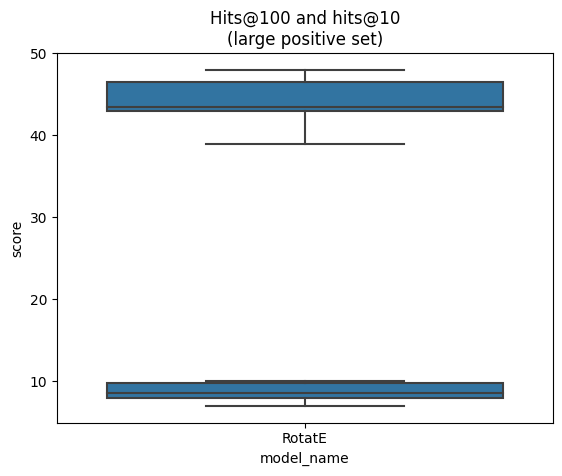

In [14]:
import seaborn as sns

sns.boxplot(score_dfs[0], x='model_name', y='score10_test').set(title='Hits@100 and hits@10\n(large positive set)')
sns.boxplot(score_dfs[0], x='model_name', y='score100_test').set_ylabel('score')

In [15]:
score_dfs[1].groupby('model_name').mean()

/tmp/ipykernel_17151/647870589.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score_dfs[1].groupby('model_name').mean()


,score10_val,score100_val,score10_test,score100_test,score10_all,score100_all,mr_all,mrr_all,amri_all,mr_test,mrr_test,amri_test,tp_test,fp_test,fn_test,tn_test,tp_all,fp_all,fn_all,tn_all
model_name,,,,,,,,,,,,,,,,,,,,
RotatE,2.2,17.3,6.8,19.7,9.0,45.5,3679.945804,0.014877,0.624099,910.2656,0.023308,0.538678,3244.7,573.3,72.1,52.9,16755.5,2533.5,145.5,140.5


Text(0, 0.5, 'score')

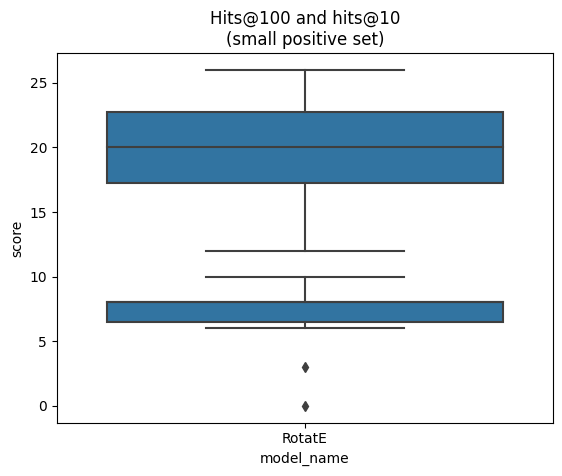

In [16]:
import seaborn as sns

sns.boxplot(score_dfs[1], x='model_name', y='score10_test').set(title='Hits@100 and hits@10\n(small positive set)')
sns.boxplot(score_dfs[1], x='model_name', y='score100_test').set_ylabel('score')

Text(0, 0.5, 'score')

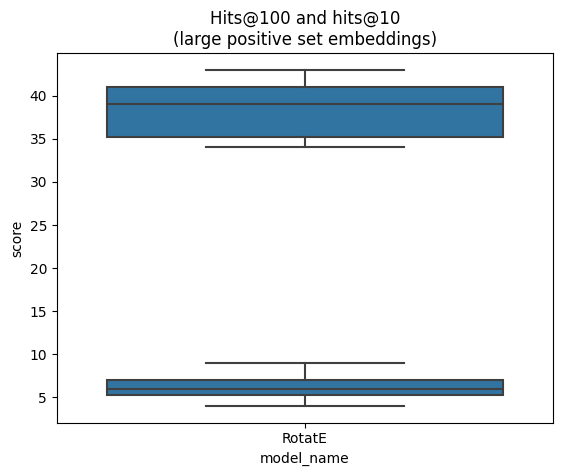

In [17]:
import seaborn as sns

sns.boxplot(score_dfs[2], x='model_name', y='score10_test').set(title='Hits@100 and hits@10\n(large positive set embeddings)')
sns.boxplot(score_dfs[2], x='model_name', y='score100_test').set_ylabel('score')

In [18]:
score_dfs = []
for output_dir in output_dirs:
    score_dfs.append(pd.read_csv(output_dir / 'score_df.csv', index_col=0))
plot_dfs = []
for ds, score_df in zip(('large', 'small', 'large_embeddings'), score_dfs):
    plot_df = score_df[['model_name', 'score10_test', 'score100_test']].copy()
    plot_df.columns = ['model_name', 'hits@10', 'hits@100']
    plot_df['dataset'] = ds
    plot_dfs.append(plot_df)

plot_df = pd.concat(plot_dfs)
plot_df = plot_df.melt(id_vars=['model_name', 'dataset'])
plot_dfs = {k:v for k, v in plot_df.groupby('model_name')}

In [19]:
y_lim = (0, 105)
y_label = 'Score'

import seaborn as sns
import matplotlib.pyplot as plt

model_name = 'TransE'
plot_df = plot_dfs[model_name]

plot_df['Hits'] = plot_df['variable']
plot = sns.barplot(plot_df, x='dataset', y='value', hue='Hits', order=['small', 'large', 'large_embeddings'])
sns.move_legend(plot, 'upper left')
plot.set(xlabel='positive dataset', ylabel=y_label)
plot.set_title(f'{model_name} - {method}')
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(labels=['small', 'large', 'large_embeddings'], rotation=0)

KeyError: 'TransE'

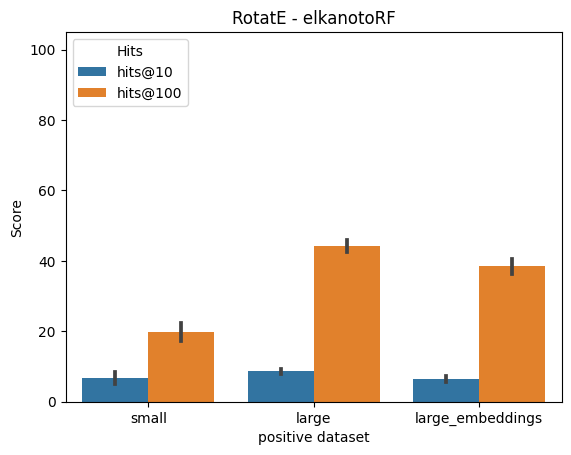

In [20]:
import seaborn as sns
model_name = 'RotatE'
plot_df = plot_dfs[model_name]
plot_df['Hits'] = plot_df['variable']
plot = sns.barplot(plot_df, x='dataset', y='value', hue='Hits', order=['small', 'large', 'large_embeddings'])
sns.move_legend(plot, 'upper left')
plot.set(xlabel='positive dataset', ylabel=y_label)
plot.set_title(f'{model_name} - {method}')
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(labels=['small', 'large', 'large_embeddings'], rotation=0)

In [24]:
def calc_predictions(grid_searches, input_dir):
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()
    
    ids = ref_df['id'].values
    y = ref_df['y'].values
    train = ref_df['train'].values
    val = ref_df['val'].values
    test = ref_df['test'].values
    
    y_preds = {}
    for model_name in grid_searches.keys():
        y_preds[model_name] = {}
        for i, m_name in enumerate(grid_searches[model_name].keys()):
            X_all = np.load(input_dir / f'{model_name}_X_{i}.npy')
            X = X_all[ids]

            grid_search = grid_searches[model_name][m_name]
            y_preds[model_name][m_name] = grid_search.predict_proba(X)
            
    return y_preds

def build_proba_df(grid_searches, input_dir):
    from pykeen.datasets import OpenBioLink
    obl = OpenBioLink()
    id_to_entity = {i:e for e, i in obl.entity_to_id.items()}
    
    y_preds = calc_predictions(grid_searches=grid_searches, input_dir=input_dir)
    
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()
    
    ids = ref_df['id'].values
    y = ref_df['y'].values
    train = ref_df['train'].values
    val = ref_df['val'].values
    test = ref_df['test'].values
    
    gene_mapping_df = pd.read_csv('../topological_features/data/gene_df.csv')
    gene_mapping_df['node_id'] = [f'NCBIGENE:{i}' for i in gene_mapping_df['gene_label']]
    gene_mapping_df = gene_mapping_df[['node_id', 'gene_name']]
    gene_map = {node_id: gene_name for _, (node_id, gene_name) in gene_mapping_df.iterrows()}
    gene_names = [gene_map[node_id] for node_id in [id_to_entity[i] for i in ids]]
    
    proba_df = pd.DataFrame(dict(
        node_id=[id_to_entity[i] for i in ids],
        gene_name=gene_names,
        irr=y,
        train=train,
        val=val,
        test=test,
        **y_preds['RotatE'],
        **y_preds['TransE'],
    ),index=ids)
    # proba_df['RotatE_sum'] = proba_df.filter(regex='RotatE_[0-9]+').sum(axis=1)
    # proba_df['TransE_sum'] = proba_df.filter(regex='TransE_[0-9]+').sum(axis=1)

    return proba_df

In [26]:
proba_dfs = [build_proba_df(gs, i) for gs, i in zip(grid_searches_list, input_dirs)]
for output_dir, proba_df in zip(output_dirs, proba_dfs):
    proba_df.to_csv(output_dir / 'proba_df.csv')

You're trying to map triples with 2052 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 2047 from 183011 triples were filtered out


KeyError: 'TransE'

In [ ]:
proba_df = proba_dfs[0]
proba_df

In [ ]:
from anngel.metrics import amri_on_proba_df, mrr_on_proba_df, mr_on_proba_df
from sklearn.metrics import confusion_matrix

def build_ranked_lists(proba_df, prefix):
    gene_lists = {}
    for i in range(10):
        col_nm = f'{prefix}_{i}'
        genes_100 = proba_df[['gene_name', col_nm]].sort_values(col_nm, ascending=False).iloc[:100]['gene_name'].values
        gene_lists[col_nm] = genes_100

    return pd.DataFrame(gene_lists)

for proba_df, score_df, od in zip(proba_dfs, score_dfs, output_dirs):
    proba_df.to_csv(od / 'proba_df.csv')
    proba_df.query('test').to_csv(od / 'proba_df_test.csv')
    score_df.to_csv(od / 'score_df.csv')
    
    for mn in MODEL_NAMES:
        score_cols = [c for c in proba_df.columns if c.startswith(f'{mn}_')]
        tmp_df = proba_df[['node_id', 'gene_name', 'irr', 'train', 'val', 'test', *score_cols]]
        tmp_df.to_csv(od / f'proba_df_{mn}.csv')
        tmp_df_test = tmp_df.query('test')
        tmp_df_test.to_csv(od / f'proba_df_test_{mn}.csv')
        
        genes_100 = build_ranked_lists(tmp_df, prefix=mn)
        genes_100.to_csv(od / f'genes_100_{mn}.csv', index=False)
        genes_100_test = build_ranked_lists(tmp_df, prefix=mn)
        genes_100_test.to_csv(od / f'genes_100_test_{mn}.csv', index=False)
        
        ds = 'test'
        score_df_tmp = score_df.query('model_name == @mn')
        score_df_tmp = pd.concat([score_df_tmp['m_name'], score_df_tmp.filter(regex=f'.*_{ds}', axis=1)], axis=1).set_index('m_name')
        score_df_tmp.columns = [c.replace(f'_{ds}', '').replace('score', 'hits@') for c in score_df_tmp.columns]
        score_df_tmp = score_df_tmp.T
        score_df_tmp['mean'] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f'scores_{ds}_{mn}.csv', index_label='score')

        ds = 'all'
        score_df_tmp = score_df.query('model_name == @mn')
        score_df_tmp = pd.concat([score_df_tmp['m_name'], score_df_tmp.filter(regex=f'.*_{ds}', axis=1)], axis=1).set_index('m_name')
        score_df_tmp.columns = [c.replace(f'_{ds}', '').replace('score', 'hits@') for c in score_df_tmp.columns]
        score_df_tmp = score_df_tmp.T
        score_df_tmp['mean'] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f'scores_{mn}.csv', index_label='score')

In [ ]:
score_df_tmp

In [ ]:
proba_df.query('test').sort_values('RotatE_0', ascending=False)

In [ ]:
s3_prefix = "s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/Result_lists"
graph = "OBL"

method = "Elkanoto_TransE"
ts = "LargeTS"
subset = "WholeSet"
!aws s3 cp './2_outputs/standard/elkanoto/proba_df_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
!aws s3 cp './2_outputs/standard/elkanoto/genes_100_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
!aws s3 cp './2_outputs/standard/elkanoto/scores_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv
subset = "TestSet"
!aws s3 cp './2_outputs/standard/elkanoto/proba_df_test_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
!aws s3 cp './2_outputs/standard/elkanoto/genes_100_test_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
!aws s3 cp './2_outputs/standard/elkanoto/scores_test_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv

ts = "SmallTS"
subset = "WholeSet"
!aws s3 cp './2_outputs/small_DS/elkanoto/proba_df_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
!aws s3 cp './2_outputs/small_DS/elkanoto/genes_100_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
!aws s3 cp './2_outputs/small_DS/elkanoto/scores_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv
subset = "TestSet"
!aws s3 cp './2_outputs/small_DS/elkanoto/proba_df_test_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
!aws s3 cp './2_outputs/small_DS/elkanoto/genes_100_test_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
!aws s3 cp './2_outputs/small_DS/elkanoto/scores_test_TransE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv

!aws s3 ls --recursive {s3_prefix}

In [36]:
s3_prefix = "s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/Result_lists"
graph = "OBL"

method = "Elkanoto_RotatE"
ts = "LargeTS"
subset = "WholeSet"
!aws s3 cp './2_outputs/standard/elkanoto/proba_df_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
!aws s3 cp './2_outputs/standard/elkanoto/genes_100_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
!aws s3 cp './2_outputs/standard/elkanoto/scores_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv
subset = "TestSet"
!aws s3 cp './2_outputs/standard/elkanoto/proba_df_test_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
!aws s3 cp './2_outputs/standard/elkanoto/genes_100_test_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
!aws s3 cp './2_outputs/standard/elkanoto/scores_test_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv

ts = "SmallTS"
subset = "WholeSet"
!aws s3 cp './2_outputs/small_DS/elkanoto/proba_df_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
!aws s3 cp './2_outputs/small_DS/elkanoto/genes_100_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
!aws s3 cp './2_outputs/small_DS/elkanoto/scores_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv
subset = "TestSet"
!aws s3 cp './2_outputs/small_DS/elkanoto/proba_df_test_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
!aws s3 cp './2_outputs/small_DS/elkanoto/genes_100_test_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
!aws s3 cp './2_outputs/small_DS/elkanoto/scores_test_RotatE.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv

!aws s3 ls --recursive {s3_prefix}

upload: 2_outputs/standard/elkanoto/proba_df_RotatE.csv to s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/Result_lists/OBL/LargeTS/Elkanoto_RotatE/WholeSet/all_results.csv
upload: 2_outputs/standard/elkanoto/genes_100_RotatE.csv to s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/Result_lists/OBL/LargeTS/Elkanoto_RotatE/WholeSet/gene_100.csv
upload: 2_outputs/standard/elkanoto/scores_RotatE.csv to s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/Result_lists/OBL/LargeTS/Elkanoto_RotatE/WholeSet/scores.csv
upload: 2_outputs/standard/elkanoto/proba_df_test_RotatE.csv to s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/Result_lists/OBL/LargeTS/Elkanoto_RotatE/TestSet/all_results.csv
upload: 2_outputs/standard/elkanoto/genes_100_test_RotatE.csv to s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects